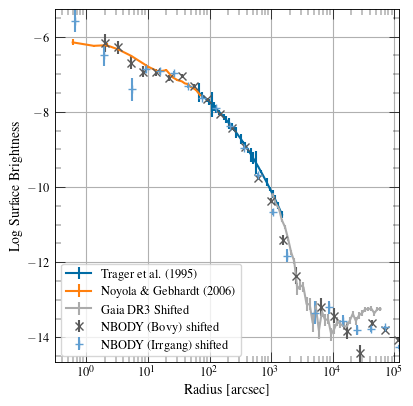

In [150]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib_inline
import orbits

mpl.style.use('default')
mpl.style.use('tableau-colorblind10')
mpl.style.use('./MNRAS_Style.mplstyle')
mpl.rcParams['figure.figsize'] = [12/3, 12/3]

SMALL_SIZE = 9
MEDIUM_SIZE = 10
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

SB = """2.025     0.01422    0.002512
       2.075     0.01482    0.002286
       2.125     0.01823    0.002259
       2.175     0.01425     0.00178
       2.225      0.0152    0.001639
       2.275     0.01405    0.001404
       2.325     0.01261    0.001186
       2.375     0.01134    0.001002
       2.425     0.01076   0.0008705
       2.475    0.007443   0.0006447
       2.525    0.007599   0.0005808
       2.575    0.005543   0.0004421
       2.625    0.004034   0.0003362
       2.675    0.003096   0.0002624
       2.725    0.002069   0.0001912
       2.775     0.00167   0.0001532
       2.825    0.001471   0.0001282
       2.875    0.001204   0.0001033
       2.925   0.0008506   7.741e-05
       2.975   0.0005197   5.393e-05
       3.025   0.0003258   2.001e-05
       3.075   0.0001854   1.346e-05
       3.125   0.0001374   1.032e-05
       3.175   6.653e-05   6.403e-06
       3.225   4.406e-05   4.643e-06
       3.275   2.138e-05   2.883e-06
       3.325   9.268e-06   1.691e-06
       3.375   5.395e-06   1.151e-06
       3.425    9.75e-07   4.357e-07
       3.475   1.239e-06   4.377e-07
       3.525   1.107e-06   3.688e-07
       3.575   3.908e-07   1.953e-07
       3.625   3.882e-07   1.734e-07
       3.675   1.233e-07   8.713e-08
       3.725   3.428e-07   1.295e-07
       3.775    7.78e-08   5.498e-08
       3.825   2.472e-07   8.734e-08
       3.875   1.472e-07   6.008e-08
       3.925    1.56e-07   5.511e-08
       3.975   6.194e-08   3.095e-08
       4.025    8.61e-08   3.253e-08
       4.075    1.34e-07   3.866e-08
       4.125   1.146e-07   3.307e-08
       4.175   1.028e-07   3.096e-08
       4.225    9.84e-08   2.967e-08
       4.275   1.409e-07   3.525e-08
       4.325   2.163e-07   4.717e-08
       4.375   1.403e-07   3.746e-08
       4.425    1.95e-07   4.252e-08
       4.475   2.259e-07   4.347e-08
       4.525   2.844e-07   4.674e-08
       4.575   2.897e-07   4.416e-08
       4.625   2.979e-07   4.299e-08
       4.675   2.239e-07   3.543e-08
       4.725   2.891e-07   3.759e-08
       4.775   2.897e-07   3.536e-08
"""

# Load Gaia profile
gaia = np.fromstring(SB, sep=' ').reshape((-1, 3))
y = -2.5*np.log10(gaia[:,1])
gaia[:,2] = -2.5*np.log10(gaia[:,1] + gaia[:,2]) - y
gaia[:,1] = y
gaia = gaia[gaia[:,0] > 3]

# Load Trager profile
trager = np.loadtxt('ngc6397_trager.dat')
trager = trager[(np.abs(trager[:,3]) < 1) & (trager[:,0] >= 1.8)] #& (trager[:,0] <= 3)]
groups = np.split(trager, np.unique(trager[:,0], return_index=True)[1][1:])
maxerr = [np.abs(a[:,3]).argmax(axis=0) for a in groups]
trager = np.array([g[m] for g,m in zip(groups, maxerr)])

rem = [(trager[1:,0] - trager[:-1,0]) < 0.03]
while np.any(rem):
    i = 1 + np.argmax(rem)
    trager = np.delete(trager, i, axis=0)
    rem = [(trager[1:,0] - trager[:-1,0]) < 0.03]

# Load Noyola profile
noyola = np.loadtxt('n6397_SB_noyola.txt')
noyola_err = np.abs(noyola[:,2])
cut_noyola = (noyola_err < 1)
noyola = noyola[cut_noyola]

# Find shift
def shift(ref_r, ref_sb, target_r, target_sb):
    mask = np.ma.masked_array(ref_r, mask=ref_r > target_r)
    left = np.ma.flatnotmasked_edges(mask)[-1]
    right = left+1
    width = ref_r[right] - ref_r[left]
    pos = target_r - ref_r[left]
    f = pos / width
    height = ref_sb[right] - ref_sb[left]
    return ref_sb[left] + height * f - target_sb

gaia_shift = shift(trager[:,0], trager[:,2], gaia[0,0], gaia[0,1])

# Build Table
sb_table = np.array([noyola[:,0], -0.4*noyola[:,1], np.abs(-0.4*noyola[:,2]), np.full(len(noyola), 1)]).T
sb_table = np.append(sb_table, np.array([trager[:,0], -0.4*trager[:,2], np.abs(-0.4*trager[:,3]), np.full(len(trager), 2)]).T, axis=0)
sb_table = np.append(sb_table, np.array([gaia[:,0], -0.4*(gaia[:,1]+gaia_shift), np.abs(-0.4*gaia[:,2]), np.full(len(gaia), 3)]).T, axis=0)
np.savetxt('sb_new.txt', sb_table, fmt=['%.3f', '%.2f', '%.3f', '%d'], delimiter=' & ', newline='\\\\\n')
#np.savetxt('sb_new.txt', sb_table, fmt=['%4.3f', '%10.6e', '%9.6e', '%d'], delimiter='    ')

# Plot
fig, ax = plt.subplots(ncols=1)
fig.tight_layout()

ax.set_xlabel(r'Radius [arcsec]')
ax.set_ylabel(r'Log Surface Brightness')
ax.set_xscale("log")
ax.grid()
#ax.invert_yaxis()
#ax.set(
#    ylim=[38, 10],
#    xlim=[0.5, 45000]
#)

ax.errorbar(10**trager[:,0], -0.4*trager[:,2], yerr=np.abs(-0.4*trager[:,3]), label='Trager et al. (1995)')
ax.errorbar(10**noyola[:,0], -0.4*noyola[:,1], yerr=np.abs(-0.4*noyola[:,2]), label='Noyola \\& Gebhardt (2006)')
ax.errorbar(10**gaia[:,0], -0.4*(gaia[:,1]+gaia_shift), yerr=np.abs(-0.4*gaia[:,2]), label='Gaia DR3 Shifted')
ax.legend(loc='lower left')

fig.savefig('sb-new.png')


nbody = np.loadtxt('2024-04-07/ngc6397.out')
nbody_irr = np.loadtxt('2024-04-28/ngc6397.out')

def get_nbdis(nb):
    m80 = (nb[:,7] > 0.8) & (nb[:,8] < 10)
    return 3600.0 * np.sqrt((nb[:,1][m80]-orbits.RA)**2 * np.cos(orbits.DEC/180.0*np.pi)**2+(nb[:,2][m80]-orbits.DEC)**2) 

nbdis = get_nbdis(nbody)
nbdis_irr = get_nbdis(nbody_irr)

def surface_density(dx, ax, label, fmt, color):
    logbins = np.logspace(np.log10(np.amin(dx)), np.log10(np.amax(dx)), 25)
    counts, edges = np.histogram(dx, bins=logbins)
    mask = counts > 0

    '''
    ra = (260, 295.5)
    dec = (-57.7, -48.5)
    r = edges[1:] / 3600
    theta = np.linspace(0, 2*np.pi, 200)
    x = orbits.RA + r[:,np.newaxis] * np.cos(theta)
    y = orbits.DEC + r[:,np.newaxis] * np.sin(theta)
    f = np.sum((x > ra[0]) & (x < ra[1]) & (y > dec[0]) & (y < dec[1]), axis=1) / 200
    print(f)
    '''

    area = np.pi * (edges[1:]**2 - edges[:-1]**2)
    n_area = (counts[mask] / area[mask])
    nsq_area = (np.sqrt(counts[mask]) / area[mask])
    sb = -2.5 * np.log10(n_area)
    error = -2.5 * np.log10(n_area+nsq_area) - sb

    sbshft = 12.9
    ax.errorbar(edges[:-1][mask], -0.4*(sb+sbshft), yerr=np.abs(-0.4*error), label=label, fmt=fmt, color=color)

surface_density(nbdis, ax, 'NBODY (Bovy) shifted', fmt='x', color='#595959')
surface_density(nbdis_irr, ax, 'NBODY (Irrgang) shifted', fmt='+', color='#5F9ED1')
ax.legend(loc='lower left')
fig.savefig('sb-new-nb.png')